In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Fri Aug  6 23:01:41 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.42.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install -U git+https://github.com/albu/albumentations --no-cache-dir
# !pip install -U segmentation-models-pytorch albumentations --user
# !pip install aicrowd-cli
# !pip install git+https://github.com/qubvel/segmentation_models.pytorch

In [4]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import shutil
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import albumentations as albu
from PIL import Image, ImageEnhance

In [5]:
from torch.utils.data import Dataset, DataLoader
from natsort import natsorted

import torch
import segmentation_models_pytorch as smp

In [6]:
DATA_DIR = '/content/drive/MyDrive/tree_segmentation/'

In [7]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

x_test_dir = os.path.join(DATA_DIR, 'test')
x_test_dir

'/content/drive/MyDrive/tree_segmentation/test'

In [8]:
# from PIL import Image, ImageEnhance
# image,mask = data4viz[return_index(4389)]
# _,g,_ = cv2.split(image)
# print(np.mean(g))
# enhancer = ImageEnhance.Brightness(Image.fromarray(image))
# for i in range(1,6,1):
#   factor = i
#   im_output = enhancer.enhance(factor)
#   im_output = np.array(im_output)
#   _,g,_ = cv2.split(im_output)
#   print(np.mean(g))
#   if np.mean(g)>100:
#     break
# plt.imshow(np.hstack((im_output,image)))
# plt.show()
# plt.imshow(mask.reshape(512,512),cmap='gray')

In [9]:
class TreeSegmentationDataset(Dataset):
  def __init__(self,
               image_directory        = None,
               segmentation_directory = None,
               train                  = True,
               augmentation           = None,
               preprocessing          = None,
               ):
    '''
        We input the directory where segmentations and their corresponding images are present.
        We also consider the augmentation object to be considered while training as well as preprocessing to be done.
    '''
    self.ids                    = os.listdir(image_directory)
    self.image_directory        = image_directory
    self.segmentation_directory = segmentation_directory
    self.augmentation           = augmentation
    self.preprocessing          = preprocessing

    if self.image_directory!=None:
      
      self.image_list           = natsorted(os.listdir(self.image_directory))
      self.segmentation_list    = natsorted(os.listdir(self.segmentation_directory))

    self.train                  = train

  def __getitem__(self,index):
    '''
        Fetches the image corresponding to a particular index from the data.
    '''

    image_location             = self.image_directory        + '/' + self.image_list[index]
    

    image_needed               = cv2.imread(image_location)
    image                      = cv2.cvtColor(image_needed, cv2.COLOR_BGR2RGB)
    
    _,g,_                      = cv2.split(image)
    enhancer                   = ImageEnhance.Brightness(Image.fromarray(image))
    for i in range(1,6,1):
      factor                   = i
      im_output                = enhancer.enhance(factor)
      im_output                = np.array(im_output)

      _,g,_ = cv2.split(im_output)
      
      if np.mean(g)>100:
        break

    image                      = im_output


    if self.train:
      segmentation_location      = self.segmentation_directory + '/' + self.segmentation_list[index]
      mask_needed                = cv2.imread(segmentation_location,0)
      mask                       = mask_needed.astype(np.float)
      mask                       = mask/255
      mask                       = mask.reshape(512,512,1)

      if self.augmentation:
        ### The augmentations will be done via albumentations library. It always returns a dictionary having 'image' and 'mask' as keys
        sample                   = self.augmentation(image = image, mask = mask)
        image,mask               = sample['image'],sample['mask']

      if self.preprocessing:
        sample                   = self.preprocessing(image = image, mask = mask)
        image,mask               = sample['image'],sample['mask']
      
      return image,mask
    else:
      
      mask                     = np.zeros((512,512,1))
      sample                   = self.preprocessing(image = image,mask=mask)
      image,mask               = sample['image'],sample['mask']
      return image
  
  def __len__(self):
        return len(self.ids)


In [10]:
data4viz = TreeSegmentationDataset(image_directory         = x_train_dir,  
                                    segmentation_directory = y_train_dir
                                  )
image,mask = data4viz[3716]

In [11]:
def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

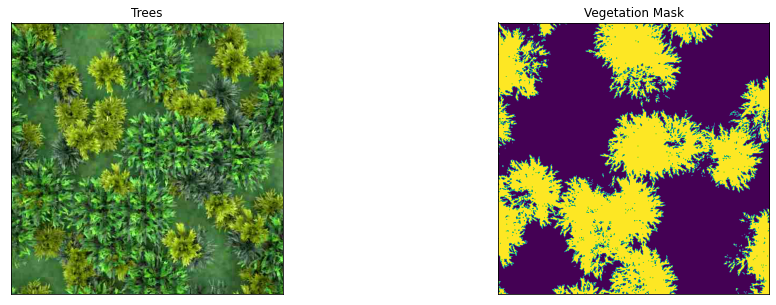

In [12]:
visualize(trees=image, vegetation_mask=mask.squeeze())

In [13]:
def get_training_augmentations():
  train_transform = [

        albu.HorizontalFlip(p=0.5),

        albu.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        
        albu.IAAAdditiveGaussianNoise(p=0.2),
        albu.IAAPerspective(p=0.5),
        albu.CLAHE(p=1),

        albu.OneOf(
            [

                albu.RandomBrightness(p=1),
#                 albu.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.IAASharpen(p=1),
                albu.Blur(blur_limit=3, p=1),
                albu.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        albu.OneOf(
            [
                albu.RandomContrast(p=1),
                albu.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
    ]
  return albu.Compose(train_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        albu.Lambda(image=preprocessing_fn),
        
        albu.Lambda(image=to_tensor, mask=to_tensor),
    ]
    return albu.Compose(_transform)

def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        albu.PadIfNeeded(512, 512)
    ]
    return albu.Compose(test_transform)


In [14]:
# x = get_training_augmentations()
# sample = x(image=image,mask = mask)
# visualize(trees=sample['image'], vegetation_mask=sample['mask'].squeeze())

In [15]:
# visualize(trees = image,vegetation_mask = mask.squeeze())

In [16]:
# augmented_train_dataset = TreeSegmentationDataset(image_directory         = x_train_dir,  
#                                                   segmentation_directory  = y_train_dir,
#                                                   augmentation            = get_training_augmentations()
#                                                   )

In [17]:
# for i in range(3):
#   image, mask = augmented_train_dataset[1]
#   visualize(trees = image,vegetation_mask = mask.squeeze())

In [18]:
ENCODER         = 'efficientnet-b4'
ENCODER_WEIGHTS = 'imagenet'

ACTIVATION      = 'sigmoid' 
DEVICE          = 'cuda'

# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=1, 
    activation=ACTIVATION,
    # decoder_dropout = 0.2,
    
    
)

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [19]:
train_dataset = TreeSegmentationDataset(
    x_train_dir, 
    y_train_dir, 
    # augmentation=get_training_augmentations(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=12)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [20]:
valid_dataset = TreeSegmentationDataset(
    x_valid_dir, 
    y_valid_dir, 
    # augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    
)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=False, num_workers=4)

In [21]:
loss =smp.utils.losses.DiceLoss(eps=1.)

metrics = [
    smp.utils.metrics.IoU(threshold=0.5,eps=1., activation = None),
    smp.utils.metrics.Fscore(threshold=0.5,eps=1., activation = None)
]

optimizer = torch.optim.AdamW([ 
    dict(params=model.parameters(), lr=0.006),
])



In [22]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,

    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [23]:
max_score = 0
extent    = 3
metric2tune = []
count = 0 
for i in range(0, 35):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['fscore']:
        max_score = valid_logs['fscore']
        torch.save(model, './best_model.pth')
        print('Model saved!')
    
    
    if valid_logs['fscore']>=0.95:
      count = count+1
      if count ==1:
        optimizer.param_groups[0]['lr'] = 0.0001
        print('lr tuned')
      if count%10==0:
        if valid_logs['fscore']<0.955:
          optimizer.param_groups[0]['lr'] = 0.00001
          print('lr tuned')
#         updated_lr,pct_change = lower_learning_rate(metric2tune,extent,optimizer.param_groups[0]['lr'])
#         print(f'Due to pct change being {pct_change},the updated lr is {updated_lr}')
#         optimizer.param_groups[0]['lr'] = updated_lr
    # if i == 25:
    #     optimizer.param_groups[0]['lr'] = 1e-5
    #     print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


valid: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s, dice_loss - 0.06786, iou_score - 0.8736, fscore - 0.9325]
Model saved!

Epoch: 1
valid: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s, dice_loss - 0.06145, iou_score - 0.8845, fscore - 0.9387]
Model saved!

Epoch: 2
valid: 100%|██████████| 63/63 [00:21<00:00,  2.97it/s, dice_loss - 0.05921, iou_score - 0.8885, fscore - 0.9409]
Model saved!

Epoch: 3
valid: 100%|██████████| 63/63 [00:21<00:00,  2.95it/s, dice_loss - 0.05776, iou_score - 0.891, fscore - 0.9424]
Model saved!

Epoch: 4
valid: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s, dice_loss - 0.05605, iou_score - 0.894, fscore - 0.944]
Model saved!

Epoch: 5
valid: 100%|██████████| 63/63 [00:21<00:00,  2.94it/s, dice_loss - 0.05605, iou_score - 0.894, fscore - 0.944]

Epoch: 6
valid: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s, dice_loss - 0.05462, iou_score - 0.8966, fscore - 0.9455]
Model saved!

Epoch: 7
valid: 100%|██████████| 63/63 [00:21<00:00,  2.93it/s, dice_loss -

In [24]:
best_model = torch.load('./best_model.pth')


In [25]:
logs = valid_epoch.run(valid_loader)


valid: 100%|██████████| 63/63 [00:21<00:00,  2.96it/s, dice_loss - 0.04745, iou_score - 0.9095, fscore - 0.9526]


In [26]:
# test dataset without transformations for image visualization


test_dataset_vis = TreeSegmentationDataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=None,
    preprocessing=None
    
)

In [27]:
for i in range(5):
    n = np.random.choice(len(valid_dataset))
    
    image_vis = test_dataset_vis[n][0].astype('uint8')
    image, gt_mask = valid_dataset[n]
    
    gt_mask = gt_mask.squeeze()
    
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
        
    visualize(
        image=image_vis, 
        ground_truth_mask=gt_mask, 
        predicted_mask=pr_mask
    )

Output hidden; open in https://colab.research.google.com to view.

In [28]:
# pr_mask.shape,gt_mask.shape

In [29]:
test_dataset = TreeSegmentationDataset(x_test_dir,train=False,preprocessing = get_preprocessing(preprocessing_fn))
test_loader = DataLoader(test_dataset, batch_size=1, num_workers=1, shuffle=False, drop_last=False)


In [30]:
predictions = []
for i in tqdm(range(len(test_dataset))):    
    image = test_dataset[i]
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    pr_mask = best_model.predict(x_tensor)
    # print(pr_mask.shape)
    pr_mask = (pr_mask.squeeze().cpu().numpy().round())
    # print(pr_mask.shape)
    predictions.append(pr_mask)    
    # print(i)

100%|██████████| 5000/5000 [28:32<00:00,  2.92it/s]


In [31]:
# # Change the channel ordering
# image = np.moveaxis(images[0].numpy()/255, 0, -1)

# # Showing the image
# plt.figure()
# plt.subplot(1,2,1)
# plt.imshow(np.moveaxis(image,-1,0), 'gray', interpolation='none')
# plt.subplot(1,2,2)
# plt.imshow(np.moveaxis(image,-1,0), 'gray', interpolation='none')
# plt.imshow(pr_mask, 'jet', interpolation='none', alpha=0.7)
# plt.show()

In [32]:
predictions[0].shape

(512, 512)

In [ ]:
!rm -rf segmentation
!mkdir segmentation

for n, img in tqdm(enumerate(predictions)):

  img = img*255
  

  _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY)
  # print(img.shape)
  # Making sure the pixels are only 0 and 255 in the image. 
  img = Image.fromarray(img.astype(np.uint8))

  
  img.save(os.path.join("segmentation", f"{n}.png"))

1393it [00:10, 130.68it/s]

In [ ]:
# !pip install aicrowd-cli


In [ ]:
%load_ext aicrowd.magic

In [ ]:
# %aicrowd login